# Chapter 2:  Exercise 2.2 Explore/Exploit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn

First we replicate figure 2.1:

In [2]:
def run_problem(n=10, T=1000, epsilon=0.01):
    q_star = np.random.normal(0, 1, [n])
    Q = np.random.normal(0, 0.0001, [n])
    counts = np.zeros(n)
    for i in xrange(T):
        greedy_choice_action = np.argmax(Q)
        actually_optimal_action = np.argmax(q_star)
        if np.random.random() < epsilon:
            action = np.random.choice(range(n))
        else:
            action = greedy_choice_action
        reward = q_star[action] + np.random.normal(0, 1)
        counts[action] += 1
        Q[action] = (Q[action] * (counts[action] - 1) + reward) / counts[action]
        yield reward, action == actually_optimal_action
 
import itertools
def run_x_problems(X=2000, make_problem=lambda: run_problem()):
    problems = [iter(make_problem()) for i in xrange(X)]
    try:
        while True:
            rewards, best_actions = zip(*[next(problem) for problem in problems])
            average_reward = np.average(rewards)
            percent_best_actions = sum((1 if best_action else 0 for best_action in best_actions)) / float(len(best_actions))
            yield average_reward, percent_best_actions
    except StopIteration:
        pass

def run_for_different_epsilons(epsilons=(0, 0.01, 0.1)):
    for eps in epsilons:
        average_rewards, percent_best_actions = zip(*list(run_x_problems(make_problem=lambda: run_problem(epsilon=eps))))
        yield eps, average_rewards, percent_best_actions
        
results = list(run_for_different_epsilons())

In [3]:
def make_plots(results, label=r"\epsilon"):
    for (eps, average_rewards, percent_best_actions) in results:
        plt.plot(np.arange(len(average_rewards)), average_rewards, label=r"$%s = %.2f$" % (label, eps))
    plt.title("Average Rewards")
    plt.legend(loc="lower right")
    plt.show()

    for (eps, average_rewards, percent_best_actions) in results:
        plt.plot(np.arange(len(percent_best_actions)), percent_best_actions, label=r"$%s = %.2f$" % (label, eps))
    plt.title("% Optimal Actions")
    plt.legend(loc="lower right")
    plt.show()

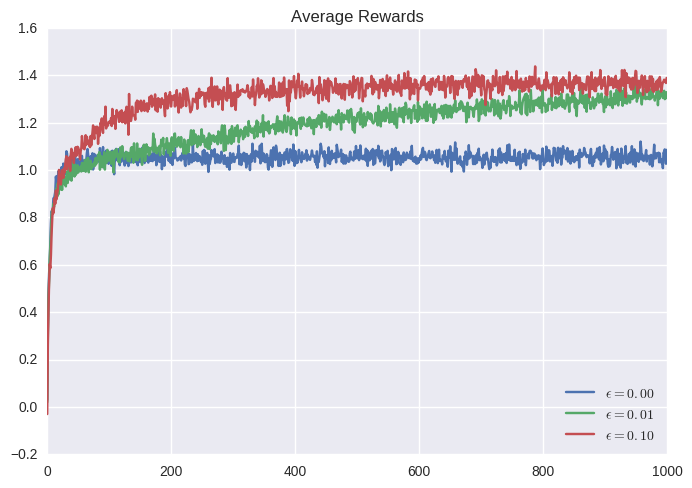

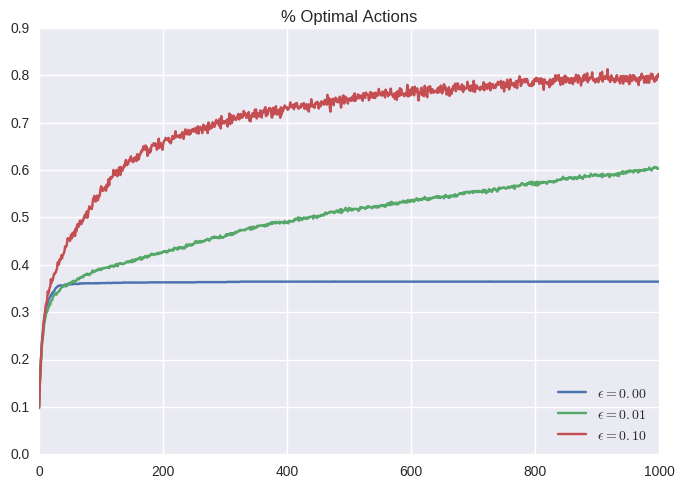

In [4]:
make_plots(results)

Next we apply softmax action selection:

In [5]:
def run_softmax_problem(n=10, T=1000, temperature=1):
    q_star = np.random.normal(0, 1, [n])
    Q = np.random.normal(0, 0.0001, [n])
    counts = np.zeros(n)
    for i in xrange(T):
        actually_optimal_action = np.argmax(q_star)
        exponents = Q / temperature
        normalized_exponents = exponents - np.max(exponents)
        exponentiated = np.exp(exponents)
        probas = exponentiated / np.sum(exponentiated)
        action = np.random.choice(range(n), p=probas)
        reward = q_star[action] + np.random.normal(0, 1)
        counts[action] += 1
        Q[action] = (Q[action] * (counts[action] - 1) + reward) / counts[action]
        yield reward, action == actually_optimal_action
        
def run_for_different_temperatures(temperatures=(0.001, 0.01, 0.1, 1)):
    for temp in temperatures:
        average_rewards, percent_best_actions = zip(*list(run_x_problems(make_problem=lambda: run_softmax_problem(temperature=temp))))
        yield temp, average_rewards, percent_best_actions

In [6]:
softmax_results = list(run_for_different_temperatures())

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in less


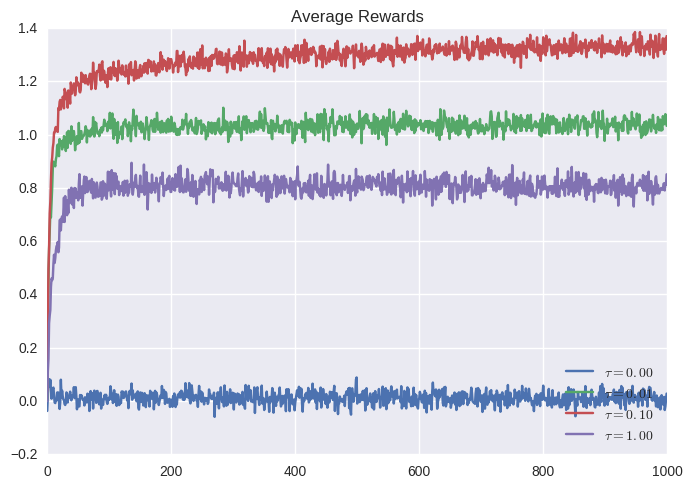

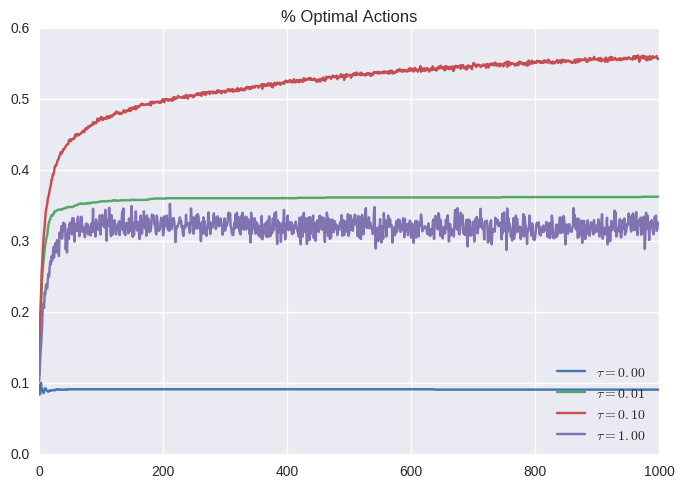

In [7]:
make_plots(softmax_results, label=r"\tau")

# Exercise 2.6:  Nonstationary Values

In [8]:
def run_nonstationary_problem(n=10, T=1000, epsilon=0.1, change_every=10, change_std=0.1, sample_averages=True):
    q_star = np.random.normal(0, 0.001, [n])
    Q = np.random.normal(0, 0.0001, [n])
    counts = np.zeros(n)
    for i in xrange(T):
        greedy_choice_action = np.argmax(Q)
        actually_optimal_action = np.argmax(q_star)
        if np.random.random() < epsilon:
            action = np.random.choice(range(n))
        else:
            action = greedy_choice_action
        reward = q_star[action] + np.random.normal(0, 1)
        counts[action] += 1
        alpha = 1 / counts[action] if sample_averages else 0.1
        Q[action] += alpha * (reward - Q[action])
        yield reward, action == actually_optimal_action
        if (i + 1) % change_every == 0:
            q_star += np.random.normal(0, change_std, [n])

In [9]:
sample_average_rewards, sample_percent_best_actions = zip(*list(run_x_problems(make_problem=lambda: run_nonstationary_problem())))
recent_average_rewards, recent_percent_best_actions = zip(*list(run_x_problems(make_problem=lambda: run_nonstationary_problem(sample_averages=False))))

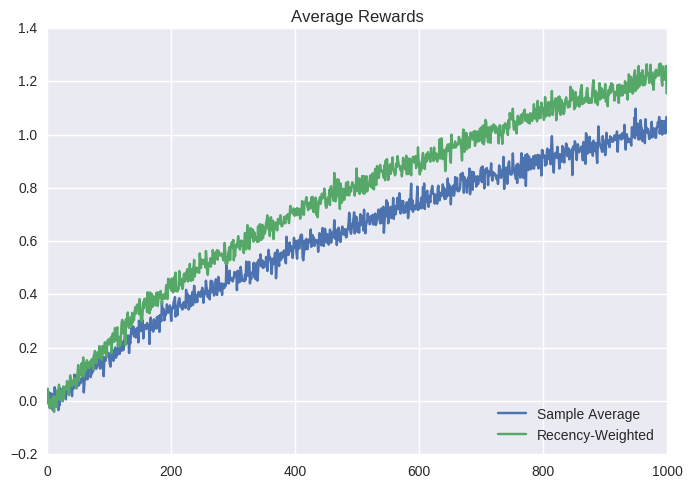

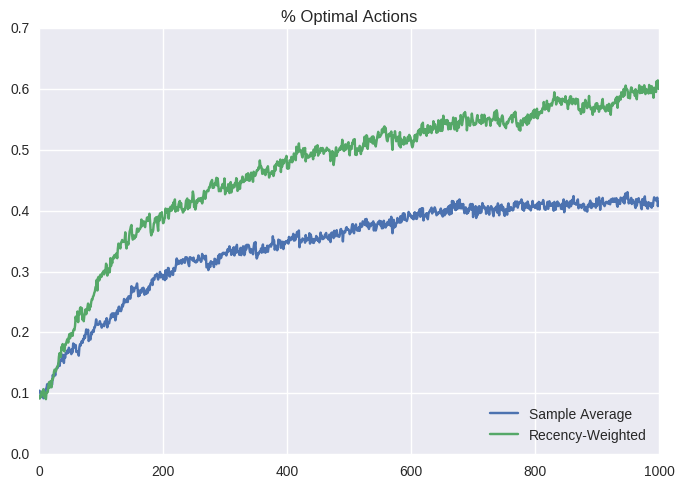

In [10]:
plt.plot(np.arange(len(sample_average_rewards)), sample_average_rewards, label="Sample Average")
plt.plot(np.arange(len(recent_average_rewards)), recent_average_rewards, label="Recency-Weighted")
plt.title("Average Rewards")
plt.legend(loc="lower right")
plt.show()

plt.plot(np.arange(len(sample_percent_best_actions)), sample_percent_best_actions, label="Sample Average")
plt.plot(np.arange(len(recent_percent_best_actions)), recent_percent_best_actions, label="Recency-Weighted")
plt.title("% Optimal Actions")
plt.legend(loc="lower right")
plt.show()